# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import glob
import random
import datetime
import warnings


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 512 # hs original is 128
IMG_HEIGHT = 512 # hs original is 128
IMG_CHANNELS = 3
TRAIN_PATH = './data/stage1_train/'
TEST_PATH = './data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Hs getData to add augmentation from yet another

In [4]:
%%time
# Get training data
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data


X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/magics/execution.py", line 1215, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 12, in <module>
  File "<timed exec>", line 7, in get_X_data
  File "<timed exec>", line 7, in <listcomp>
  File "/anaconda/envs/py35/lib/python3.5/site-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1806, in showtrace

KeyboardInterrupt: 

In [5]:
%%time
# Get training data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data


Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 128, 128, 1) bool
CPU times: user 38.9 s, sys: 1.03 s, total: 40 s
Wall time: 40 s


In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 97.96it/s] 

Done!


In [6]:
# Runtime data augmentation
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.25, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask  
    

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [08:59<00:00,  1.24it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:04<00:00, 13.12it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

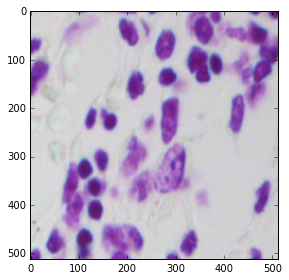

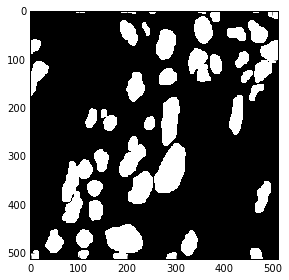

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

<font color=red>HS update: Yet another uses the exact same mean_iou so it might be correct after all</font>

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## hs my u-net 512*512

In [10]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#(None, 512, 512, 3)

s = Lambda(lambda x: x / 255) (inputs)
#(None, 512, 512, 3)



c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
#(None, 512, 512, 16)

c1 = Dropout(0.1) (c1)
#(None, 512, 512, 16)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
#(None, 512, 512, 16)

p1 = MaxPooling2D((2, 2)) (c1)
#(None, 256, 256, 16) 



c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
#(None, 256, 256, 32)

c2 = Dropout(0.1) (c2)
#(None, 256, 256, 32)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
#(None, 256, 256, 32)

p2 = MaxPooling2D((2, 2)) (c2)
#(None, 128, 128, 32)



c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
#(None, 128, 128, 64)

c3 = Dropout(0.2) (c3)
#(None, 128, 128, 64)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
#(None, 128, 128, 64)

p3 = MaxPooling2D((2, 2)) (c3)
#(None, 64, 64, 64)



c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
#(None, 64, 64, 128)

c4 = Dropout(0.2) (c4)
#(None, 64, 64, 128)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
#(None, 64, 64, 128)

p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#(None, 32, 32, 128)




#hs 1 adding new layers here
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#(None, 32, 32, 256)

c5 = Dropout(0.2) (c5)
#(None, 32, 32, 256)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
#(None, 32, 32, 256)

p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
#(None, 16, 16, 256)



#hs 2 adding new layers here
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
#(None, 16, 16, 512)

c6 = Dropout(0.2) (c6)
#(None, 16, 16, 512)

c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
#(None, 16, 16, 512)

p6 = MaxPooling2D(pool_size=(2, 2)) (c6)
#(None, 8, 8, 512)



# hs 4 must change c5 to c7 and 256 to 1024
c7 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p6)
#(None, 8, 8, 1024)

c7 = Dropout(0.3) (c7)
#(None, 8, 8, 1024)

c7 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
#(None, 8, 8, 1024)







# hs 5 must change u6 to u8 and 128 to 512
u8 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c7)
#(None, 16, 16, 512)

u8 = concatenate([u8, c6]) #change c4 to c6
#(None, 16, 16, 1024)

c8 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
#(None, 16, 16, 512) 

c8 = Dropout(0.2) (c8)
#(None, 16, 16, 512)

c8 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
#(None, 16, 16, 512)



# hs 6 must change u7 to u9 and 64 to 256
u9 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c8)
#(None, 32, 32, 64)

u9 = concatenate([u9, c5]) #change c3 to c5
#(None, 32, 32, 512)

c9 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
#(None, 32, 32, 256) 

c9 = Dropout(0.2) (c9)
#(None, 32, 32, 256)

c9 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
#(None, 32, 32, 256)



# hs 7 must change u8 to u10 and 32 to 128
u10 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c9)
#(None, 64, 64, 128)

u10 = concatenate([u10, c4])  #change c2 to c4
#(None, 64, 64, 256)

c10 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
#(None, 64, 64, 128)

c10 = Dropout(0.1) (c10)
#(None, 64, 64, 128)

c10 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)
#(None, 64, 64, 128)



# hs 8 must change u9 to u11 and 16 to 64
u11 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c10)
#(None, 128, 128, 64)

u11 = concatenate([u11, c3], axis=3) #change c1 to c3
#(None, 128, 128, 128)

c11 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
#(None, 128, 128, 64)

c11 = Dropout(0.1) (c11)
#(None, 128, 128, 64)

c11 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)
#(None, 128, 128, 64)



# hs 9 must change u11 to u12 and 8 to 32
u12 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c11)
#(None, 128, 128, 32)

u12 = concatenate([u12, c2], axis=3) #change c0 to c2
#(None, 128, 128, 64)

c12 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u12)
#(None, 128, 128, 32)

c12 = Dropout(0.1) (c12)
#(None, 128, 128, 32)

c12 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c12)
#(None, 128, 128, 32)



# hs 10 must change u11 to u13 and leave this at 16
u13 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c12)
#(None, 128, 128, 16)

u13 = concatenate([u13, c1], axis=3) #change c-1 to c1
#(None, 128, 128, 32)

c13 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u13)
#(None, 128, 128, 16)

c13 = Dropout(0.1) (c13)
#(None, 128, 128, 16)

c13 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c13)
#(None, 128, 128, 16)




outputs = Conv2D(1, (1, 1), activation='sigmoid') (c13)
#(None, 128, 128, 1)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 512, 512, 16) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 

## hs original u-net 128*128

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#(None, 128, 128, 3)

s = Lambda(lambda x: x / 255) (inputs)
#(None, 128, 128, 3)



c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
#(None, 128, 128, 16)

c1 = Dropout(0.1) (c1)
#(None, 128, 128, 16)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
#(None, 128, 128, 16)

p1 = MaxPooling2D((2, 2)) (c1)
#(None, 64, 64, 16) 



c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
#(None, 64, 64, 32)

c2 = Dropout(0.1) (c2)
#(None, 64, 64, 32)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
#(None, 64, 64, 32)

p2 = MaxPooling2D((2, 2)) (c2)
#(None, 32, 32, 32)



c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
#(None, 32, 32, 64)

c3 = Dropout(0.2) (c3)
#(None, 32, 32, 64)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
#(None, 32, 32, 64)

p3 = MaxPooling2D((2, 2)) (c3)
#(None, 16, 16, 64)



c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
#(None, 16, 16, 128)

c4 = Dropout(0.2) (c4)
#(None, 16, 16, 128)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
#(None, 16, 16, 128)

p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#(None, 8, 8, 128)



c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#(None, 8, 8, 256)

c5 = Dropout(0.3) (c5)
#(None, 8, 8, 256)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
#(None, 8, 8, 256)






u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
#(None, 16, 16, 128)

u6 = concatenate([u6, c4])
#(None, 16, 16, 256)

c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
#(None, 16, 16, 128) 

c6 = Dropout(0.2) (c6)
#(None, 16, 16, 128)

c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
#(None, 16, 16, 128)


u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
#(None, 32, 32, 64)

u7 = concatenate([u7, c3])
#(None, 32, 32, 128)

c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
#(None, 32, 32, 64) 

c7 = Dropout(0.2) (c7)
#(None, 32, 32, 64)

c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
#(None, 32, 32, 64)



u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
#(None, 64, 64, 32)

u8 = concatenate([u8, c2])
#(None, 64, 64, 64)

c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
#(None, 64, 64, 32)

c8 = Dropout(0.1) (c8)
#(None, 64, 64, 32)

c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
#(None, 64, 64, 32)



u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
#(None, 128, 128, 16)

u9 = concatenate([u9, c1], axis=3)
#(None, 128, 128, 32)

c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
#(None, 128, 128, 16)

c9 = Dropout(0.1) (c9)
#(None, 128, 128, 16)

c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
#(None, 128, 128, 16)



outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
#(None, 128, 128, 1)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Update: Changed to ELU units, added dropout.

##  Training hs version with dataAugmentation

In [ ]:
# Finally train the model!!
batch_size = 16
epochs = 50
validationSplit = 0.11


train_generator, test_generator = get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=validationSplit, batch_size=batch_size)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)


model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=epochs, callbacks=[earlystopper, checkpointer])

## Training orig

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. 

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-hs-UNet-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 108s 180ms/step - loss: 0.4606 - mean_iou: 0.4139 - val_loss: 0.3837 - val_mean_iou: 0.4336
Epoch 2/50
603/603 [==============================] - 96s 159ms/step - loss: 0.2240 - mean_iou: 0.4729 - val_loss: 0.1559 - val_mean_iou: 0.5273
Epoch 3/50
208/603 [=========>....................] - ETA: 57s - loss: 0.1727 - mean_iou: 0.5410

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [12]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 4ms/step


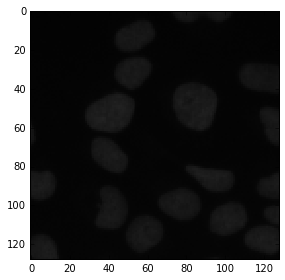

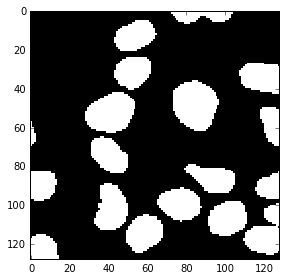

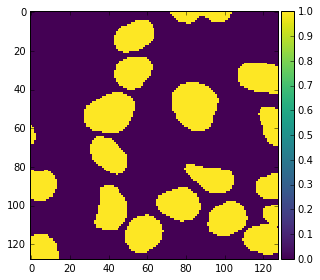

In [12]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

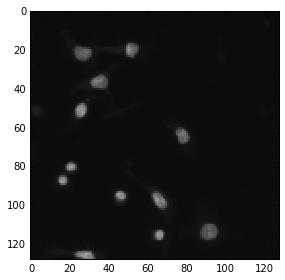

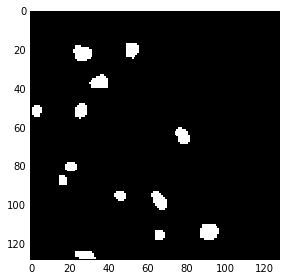

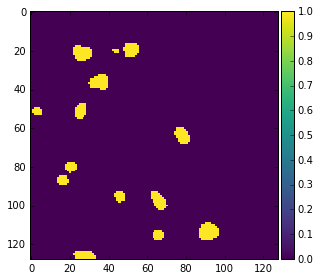

In [13]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [13]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [14]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [15]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('subm_uNet_' + str(datetime.datetime.now()) + '.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB

# hs Reinforcement Learning

In [56]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
X_test.shape

(65, 128, 128, 3)

In [29]:
preds_test = model.predict(X_test[0:1,:,:,:], verbose=1)

1/1 [==============================] - 18s 18s/step


In [32]:
preds_test.shape

(1, 128, 128, 1)

### hs preds_test is a probability map, where the value for each pixel shows the prob that it is a cell neclei

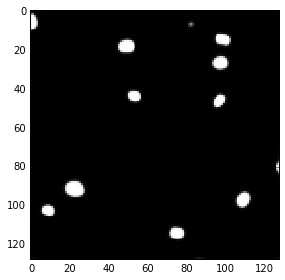

In [34]:
imshow(np.squeeze(preds_test))
plt.show()

In [18]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]

['input_1',
 'lambda_1',
 'conv2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_1',
 'conv2d_3',
 'dropout_2',
 'conv2d_4',
 'max_pooling2d_2',
 'conv2d_5',
 'dropout_3',
 'conv2d_6',
 'max_pooling2d_3',
 'conv2d_7',
 'dropout_4',
 'conv2d_8',
 'max_pooling2d_4',
 'conv2d_9',
 'dropout_5',
 'conv2d_10',
 'conv2d_transpose_1',
 'concatenate_1',
 'conv2d_11',
 'dropout_6',
 'conv2d_12',
 'conv2d_transpose_2',
 'concatenate_2',
 'conv2d_13',
 'dropout_7',
 'conv2d_14',
 'conv2d_transpose_3',
 'concatenate_3',
 'conv2d_15',
 'dropout_8',
 'conv2d_16',
 'conv2d_transpose_4',
 'concatenate_4',
 'conv2d_17',
 'dropout_9',
 'conv2d_18',
 'conv2d_19']

In [21]:
model.layers

In [23]:
len(model.layers)

42

In [22]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]

['input_1',
 'lambda_1',
 'conv2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_1',
 'conv2d_3',
 'dropout_2',
 'conv2d_4',
 'max_pooling2d_2',
 'conv2d_5',
 'dropout_3',
 'conv2d_6',
 'max_pooling2d_3',
 'conv2d_7',
 'dropout_4',
 'conv2d_8',
 'max_pooling2d_4',
 'conv2d_9',
 'dropout_5',
 'conv2d_10',
 'conv2d_transpose_1',
 'concatenate_1',
 'conv2d_11',
 'dropout_6',
 'conv2d_12',
 'conv2d_transpose_2',
 'concatenate_2',
 'conv2d_13',
 'dropout_7',
 'conv2d_14',
 'conv2d_transpose_3',
 'concatenate_3',
 'conv2d_15',
 'dropout_8',
 'conv2d_16',
 'conv2d_transpose_4',
 'concatenate_4',
 'conv2d_17',
 'dropout_9',
 'conv2d_18',
 'conv2d_19']

In [47]:
x = model.layers[41]

IndexError: list index out of range

In [51]:
x = layer_dict['conv2d_18']

In [ ]:
xx = model.get_layer('conv2d_18').output

In [64]:
x.output

<tf.Tensor 'conv2d_18_2/Elu:0' shape=(?, 128, 128, 16) dtype=float32>

In [62]:
xx

<tf.Tensor 'conv2d_18_3/Elu:0' shape=(?, 128, 128, 16) dtype=float32>

In [65]:
new_baseMod = Model(model.input, xx)

In [66]:
new_baseMod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [68]:
yy = model.get_layer('conv2d_19') (xx)

In [69]:
new_model = Model(model.input, yy)

In [71]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

1/1 [==============================] - 0s 327ms/step


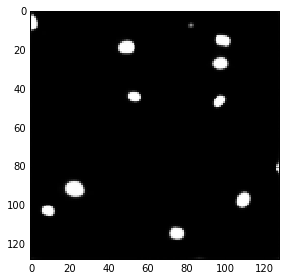

In [72]:
preds_test = new_model.predict(X_test[0:1,:,:,:], verbose=1)
imshow(np.squeeze(preds_test))
plt.show()